# Image segmentation (3D UNET)
[인공지능을 이용한 의료영상처리 및 실습] 

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 714 kB 5.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path0 = '/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train'
dpiv = 80

In [ ]:
from monai.transforms import *
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first

from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [ ]:
path_list = glob.glob(os.path.join(path0,'Brats18*'))
len(path_list)

100

### data split (train/valid)

In [ ]:
train_ind = np.arange(0,64)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in train_ind
]
train_files =  data_dicts

In [ ]:
valid_ind = np.arange(64,80)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in valid_ind
]
valid_files =  data_dicts

In [ ]:
train_transforms = Compose(
    [
      LoadImaged(keys=("image","label")),
      AddChanneld(keys=("image","label")),
      CenterSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 96]),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      RandSpatialCropd(keys=["image", "label"], roi_size=[160, 160, 64],random_size=False),
      Affined(
        keys=["image", "label"], 
        shear_params=(0.2, 0.5, 0),
        mode=['bilinear', 'nearest'],
        translate_params=(10, 10),
        padding_mode="zeros",
      ),
      ToTensord(keys=["image", "label"]),
    ]
)

valid_transforms = Compose(
    [
      LoadImaged(keys=("image","label")),
      AddChanneld(keys=("image","label")),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      ToTensord(keys=["image", "label"]),
    ]
)

In [ ]:
train_ds = Dataset(data = train_files, transform = train_transforms)
train_loader = DataLoader(train_ds,batch_size = 2)

In [ ]:
valid_ds = Dataset(data = valid_files, transform = valid_transforms)
valid_loader = DataLoader(valid_ds,batch_size = 1)

- check transformation

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([2, 1, 160, 160, 64])
torch.Size([2, 1, 160, 160, 64])


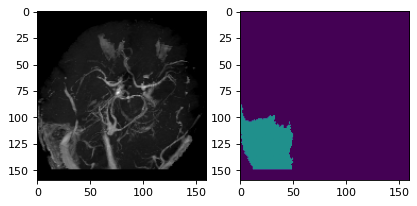

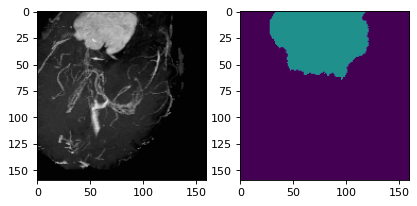

In [ ]:
cnt = 0
for data in train_loader:
  print(data["image"].shape)
  print(data["label"].shape)

  for n in range(0,len(data["image"])):
    plt.figure(dpi=dpiv)
    plt.subplot(121)
    plt.imshow(np.transpose(np.max(data["image"][n,0,:,:,:].numpy(),axis=2),(1,0)),cmap='gray')

    label = (data["label"]==1).type(torch.FloatTensor) + (data["label"]==2).type(torch.FloatTensor) + (data["label"]==4).type(torch.FloatTensor) 
    plt.subplot(122)
    plt.imshow(np.transpose(np.max(label[n,0,:,:,:].numpy(),axis=2),(1,0)),vmin=0,vmax=2)
    plt.show()

  break


# Model

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(8, 16, 32, 64),
    strides=(2, 2, 2, 2),
    num_res_units=3,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)


/usr/local/lib/python3.7/dist-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


# Train

----------
epoch 1/100
epoch 1 average loss: 0.6118
----------
epoch 2/100
epoch 2 average loss: 0.5224
----------
epoch 3/100
epoch 3 average loss: 0.4253
----------
epoch 4/100
epoch 4 average loss: 0.3506
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA03_121_1/t1ce.nii.gz']


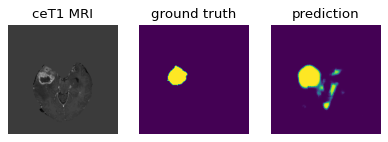

saved new best metric model
current epoch: 4 current mean dice: 0.6537
best mean dice: 0.6537 at epoch: 4
----------
epoch 5/100
epoch 5 average loss: 0.3317
----------
epoch 6/100
epoch 6 average loss: 0.3083
----------
epoch 7/100
epoch 7 average loss: 0.2725
----------
epoch 8/100
epoch 8 average loss: 0.3005
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_473_1/t1ce.nii.gz']


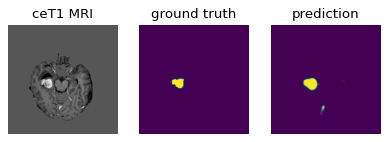

saved new best metric model
current epoch: 8 current mean dice: 0.7444
best mean dice: 0.7444 at epoch: 8
----------
epoch 9/100
epoch 9 average loss: 0.2726
----------
epoch 10/100
epoch 10 average loss: 0.2650
----------
epoch 11/100
epoch 11 average loss: 0.2759
----------
epoch 12/100
epoch 12 average loss: 0.2728
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_208_1/t1ce.nii.gz']


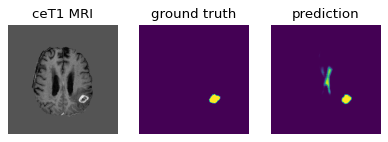

saved new best metric model
current epoch: 12 current mean dice: 0.7921
best mean dice: 0.7921 at epoch: 12
----------
epoch 13/100
epoch 13 average loss: 0.2354
----------
epoch 14/100
epoch 14 average loss: 0.2598
----------
epoch 15/100
epoch 15 average loss: 0.2545
----------
epoch 16/100
epoch 16 average loss: 0.2376
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_605_1/t1ce.nii.gz']


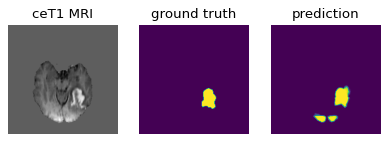

saved new best metric model
current epoch: 16 current mean dice: 0.8074
best mean dice: 0.8074 at epoch: 16
----------
epoch 17/100
epoch 17 average loss: 0.2472
----------
epoch 18/100
epoch 18 average loss: 0.2170
----------
epoch 19/100
epoch 19 average loss: 0.2107
----------
epoch 20/100
epoch 20 average loss: 0.2204
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_179_1/t1ce.nii.gz']


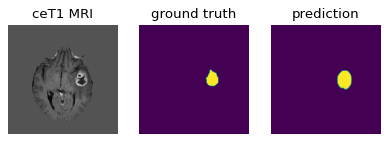

saved new best metric model
current epoch: 20 current mean dice: 0.8263
best mean dice: 0.8263 at epoch: 20
----------
epoch 21/100
epoch 21 average loss: 0.1895
----------
epoch 22/100
epoch 22 average loss: 0.2070
----------
epoch 23/100
epoch 23 average loss: 0.1967
----------
epoch 24/100
epoch 24 average loss: 0.2078
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_473_1/t1ce.nii.gz']


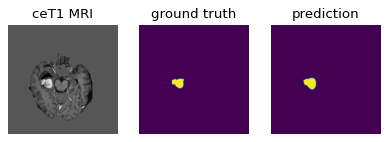

current epoch: 24 current mean dice: 0.8038
best mean dice: 0.8263 at epoch: 20
----------
epoch 25/100
epoch 25 average loss: 0.2172
----------
epoch 26/100
epoch 26 average loss: 0.1849
----------
epoch 27/100
epoch 27 average loss: 0.1855
----------
epoch 28/100
epoch 28 average loss: 0.1969
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_300_1/t1ce.nii.gz']


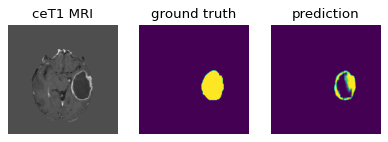

saved new best metric model
current epoch: 28 current mean dice: 0.8558
best mean dice: 0.8558 at epoch: 28
----------
epoch 29/100
epoch 29 average loss: 0.1826
----------
epoch 30/100
epoch 30 average loss: 0.1646
----------
epoch 31/100
epoch 31 average loss: 0.1934
----------
epoch 32/100
epoch 32 average loss: 0.1742
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_394_1/t1ce.nii.gz']


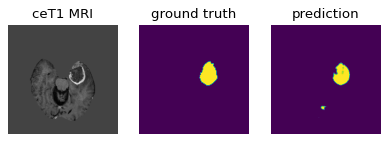

current epoch: 32 current mean dice: 0.8366
best mean dice: 0.8558 at epoch: 28
----------
epoch 33/100
epoch 33 average loss: 0.1736
----------
epoch 34/100
epoch 34 average loss: 0.1713
----------
epoch 35/100
epoch 35 average loss: 0.1796
----------
epoch 36/100
epoch 36 average loss: 0.1299
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_473_1/t1ce.nii.gz']


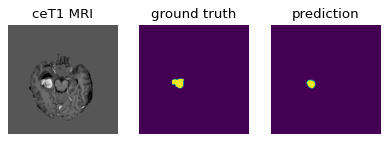

current epoch: 36 current mean dice: 0.8492
best mean dice: 0.8558 at epoch: 28
----------
epoch 37/100
epoch 37 average loss: 0.1403
----------
epoch 38/100
epoch 38 average loss: 0.1545
----------
epoch 39/100
epoch 39 average loss: 0.1491
----------
epoch 40/100
epoch 40 average loss: 0.1560
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_322_1/t1ce.nii.gz']


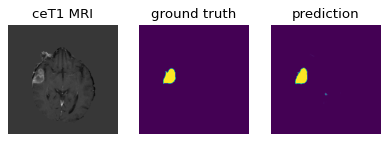

current epoch: 40 current mean dice: 0.8360
best mean dice: 0.8558 at epoch: 28
----------
epoch 41/100
epoch 41 average loss: 0.1677
----------
epoch 42/100
epoch 42 average loss: 0.1497
----------
epoch 43/100
epoch 43 average loss: 0.1365
----------
epoch 44/100
epoch 44 average loss: 0.1338
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_473_1/t1ce.nii.gz']


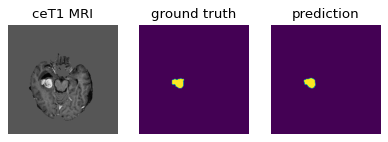

saved new best metric model
current epoch: 44 current mean dice: 0.8753
best mean dice: 0.8753 at epoch: 44
----------
epoch 45/100
epoch 45 average loss: 0.1444
----------
epoch 46/100
epoch 46 average loss: 0.1566
----------
epoch 47/100
epoch 47 average loss: 0.1391
----------
epoch 48/100
epoch 48 average loss: 0.1425
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_283_1/t1ce.nii.gz']


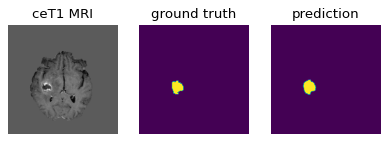

current epoch: 48 current mean dice: 0.8694
best mean dice: 0.8753 at epoch: 44
----------
epoch 49/100
epoch 49 average loss: 0.1306
----------
epoch 50/100
epoch 50 average loss: 0.1277
----------
epoch 51/100
epoch 51 average loss: 0.1115
----------
epoch 52/100
epoch 52 average loss: 0.1205
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_322_1/t1ce.nii.gz']


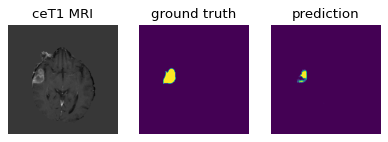

current epoch: 52 current mean dice: 0.8293
best mean dice: 0.8753 at epoch: 44
----------
epoch 53/100
epoch 53 average loss: 0.1356
----------
epoch 54/100
epoch 54 average loss: 0.1299
----------
epoch 55/100
epoch 55 average loss: 0.1488
----------
epoch 56/100
epoch 56 average loss: 0.1407
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA03_121_1/t1ce.nii.gz']


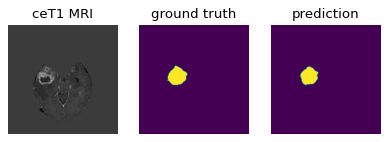

current epoch: 56 current mean dice: 0.8712
best mean dice: 0.8753 at epoch: 44
----------
epoch 57/100
epoch 57 average loss: 0.1221
----------
epoch 58/100
epoch 58 average loss: 0.1211
----------
epoch 59/100
epoch 59 average loss: 0.1112
----------
epoch 60/100
epoch 60 average loss: 0.1066
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_322_1/t1ce.nii.gz']


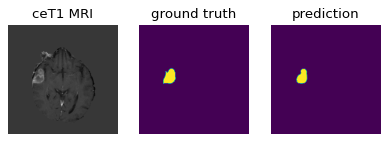

saved new best metric model
current epoch: 60 current mean dice: 0.9050
best mean dice: 0.9050 at epoch: 60
----------
epoch 61/100
epoch 61 average loss: 0.1201
----------
epoch 62/100
epoch 62 average loss: 0.1092
----------
epoch 63/100
epoch 63 average loss: 0.1037
----------
epoch 64/100
epoch 64 average loss: 0.1293
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_394_1/t1ce.nii.gz']


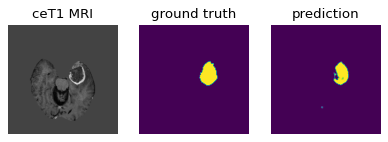

current epoch: 64 current mean dice: 0.8800
best mean dice: 0.9050 at epoch: 60
----------
epoch 65/100
epoch 65 average loss: 0.1207
----------
epoch 66/100
epoch 66 average loss: 0.1233
----------
epoch 67/100
epoch 67 average loss: 0.1273
----------
epoch 68/100
epoch 68 average loss: 0.1094
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_208_1/t1ce.nii.gz']


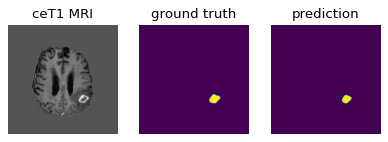

current epoch: 68 current mean dice: 0.8748
best mean dice: 0.9050 at epoch: 60
----------
epoch 69/100
epoch 69 average loss: 0.1078
----------
epoch 70/100
epoch 70 average loss: 0.1205
----------
epoch 71/100
epoch 71 average loss: 0.1354
----------
epoch 72/100
epoch 72 average loss: 0.1087
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_208_1/t1ce.nii.gz']


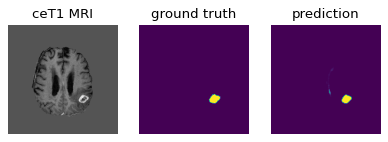

current epoch: 72 current mean dice: 0.8907
best mean dice: 0.9050 at epoch: 60
----------
epoch 73/100
epoch 73 average loss: 0.0946
----------
epoch 74/100
epoch 74 average loss: 0.1176
----------
epoch 75/100
epoch 75 average loss: 0.1037
----------
epoch 76/100
epoch 76 average loss: 0.1052
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_179_1/t1ce.nii.gz']


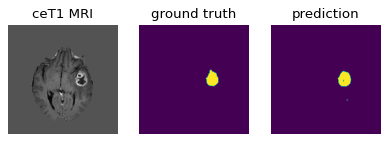

current epoch: 76 current mean dice: 0.8396
best mean dice: 0.9050 at epoch: 60
----------
epoch 77/100
epoch 77 average loss: 0.1183
----------
epoch 78/100
epoch 78 average loss: 0.1171
----------
epoch 79/100
epoch 79 average loss: 0.0905
----------
epoch 80/100
epoch 80 average loss: 0.0970
saved new best metric model
current epoch: 80 current mean dice: 0.9155
best mean dice: 0.9155 at epoch: 80
----------
epoch 81/100
epoch 81 average loss: 0.1107
----------
epoch 82/100
epoch 82 average loss: 0.0975
----------
epoch 83/100
epoch 83 average loss: 0.1169
----------
epoch 84/100
epoch 84 average loss: 0.0825
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA01_401_1/t1ce.nii.gz']


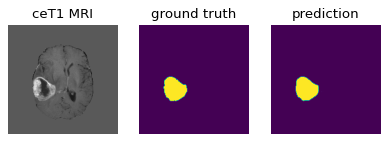

current epoch: 84 current mean dice: 0.9120
best mean dice: 0.9155 at epoch: 80
----------
epoch 85/100
epoch 85 average loss: 0.0838
----------
epoch 86/100
epoch 86 average loss: 0.0726
----------
epoch 87/100
epoch 87 average loss: 0.1029
----------
epoch 88/100
epoch 88 average loss: 0.0818
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_208_1/t1ce.nii.gz']


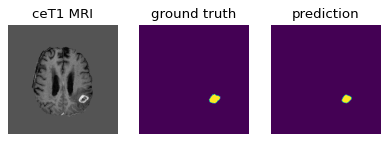

current epoch: 88 current mean dice: 0.9078
best mean dice: 0.9155 at epoch: 80
----------
epoch 89/100
epoch 89 average loss: 0.1068
----------
epoch 90/100
epoch 90 average loss: 0.0886
----------
epoch 91/100
epoch 91 average loss: 0.1065
----------
epoch 92/100
epoch 92 average loss: 0.1247
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_322_1/t1ce.nii.gz']


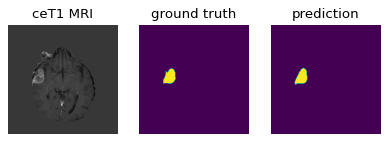

current epoch: 92 current mean dice: 0.8930
best mean dice: 0.9155 at epoch: 80
----------
epoch 93/100
epoch 93 average loss: 0.1127
----------
epoch 94/100
epoch 94 average loss: 0.1339
----------
epoch 95/100
epoch 95 average loss: 0.1131
----------
epoch 96/100
epoch 96 average loss: 0.0780
['/content/drive/MyDrive/Colab Notebooks/brats18_train/brats18_train/Brats18_TCIA02_283_1/t1ce.nii.gz']


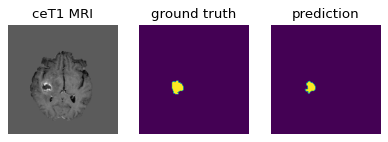

current epoch: 96 current mean dice: 0.8942
best mean dice: 0.9155 at epoch: 80
----------
epoch 97/100
epoch 97 average loss: 0.0972
----------
epoch 98/100
epoch 98 average loss: 0.1307
----------
epoch 99/100
epoch 99 average loss: 0.1120
----------
epoch 100/100
epoch 100 average loss: 0.0922
current epoch: 100 current mean dice: 0.8946
best mean dice: 0.9155 at epoch: 80


In [ ]:
root_dir = path0 # model will be saved in this folder

lr = 1e-3
max_epochs = 100
val_interval = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

optimizer = torch.optim.Adam(model.parameters(), lr)

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"],
        )

        labels = (labels==1).type(torch.FloatTensor) + (labels==4).type(torch.FloatTensor)
        labels[labels>0] = 1
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
 
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            disp_val_no = np.random.randint(len(valid_files))
            for val_data in valid_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"],
                )        

                val_labels = (val_labels==1).type(torch.FloatTensor) + (val_labels==4).type(torch.FloatTensor)
                val_labels[val_labels>0] = 1
                val_labels = val_labels.to(device)
                
                roi_size = (160, 160, 64)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model, overlap=0.75)
                val_loss = loss_function(val_outputs, val_labels)
                
                metric_count += 1
                metric_sum += (1-val_loss.sum().item())
                
                if metric_count == disp_val_no:
                  print(val_data['image_meta_dict']['filename_or_obj'])
                  zz = np.argmax(np.sum(np.sum(np.array(val_labels[0,0,:,:,:].cpu()),axis=1),axis=0))
                  val_preds = val_outputs.softmax(1)
                  plt.figure(dpi=dpiv)
                  plt.subplot(131)
                  plt.imshow(np.transpose(val_inputs[0,0,:,:,zz].cpu().numpy(),(1,0)),cmap='gray')
                  plt.axis('off')
                  plt.title('ceT1 MRI')
                  plt.subplot(132)
                  plt.imshow(np.transpose(val_labels[0,0,:,:,zz].cpu().numpy(),(1,0)))
                  plt.axis('off')
                  plt.title('ground truth')
                  plt.subplot(133)
                  plt.imshow(np.transpose(val_preds[0,1,:,:,zz].cpu().numpy(),(1,0)))
                  plt.axis('off')
                  plt.title('prediction')
                  plt.show()
                
            metric = metric_sum / metric_count
            metric_values.append(metric)
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, f"best_metric_model_epoch_{best_metric_epoch}.pth"))    
                print("saved new best metric model")
            
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}")

## plot the loss and metric

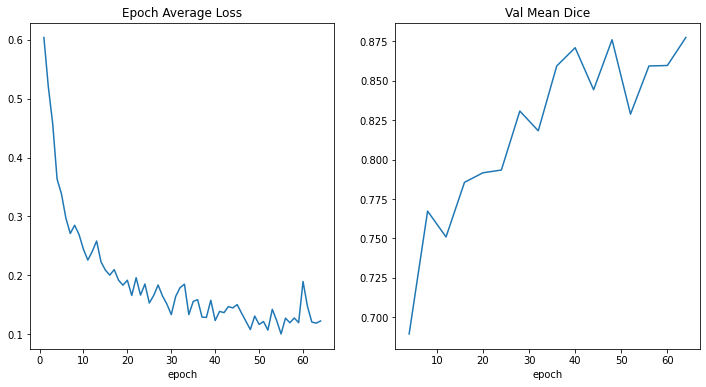

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()